## Cleaned MLP Code

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {
    s: i+1 for i,s in enumerate(chars)
}
stoi['.'] = 0
itos = { i:s for s,i in stoi.items() }

In [4]:
vocab_size =len(itos)
vocab_size

27

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% training size
Xdev, Ydev = build_dataset(words[n1:n2]) #10% validation/dev
Xte, Yte = build_dataset(words[n2:])#10% test size

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [33]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)


parameters = [C, W1, W2,b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [34]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1+b1 #+ b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 27.8817
  10000/ 200000: 2.8137
  20000/ 200000: 2.5107
  30000/ 200000: 2.8047
  40000/ 200000: 2.0610
  50000/ 200000: 2.6743
  60000/ 200000: 2.3679
  70000/ 200000: 2.0702
  80000/ 200000: 2.2550
  90000/ 200000: 2.2825
 100000/ 200000: 2.0023
 110000/ 200000: 2.3095
 120000/ 200000: 1.8914
 130000/ 200000: 2.4168
 140000/ 200000: 2.2163
 150000/ 200000: 2.1790
 160000/ 200000: 2.0718
 170000/ 200000: 1.7637
 180000/ 200000: 2.0273
 190000/ 200000: 1.8378


In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1256096363067627
val 2.1673810482025146


In [36]:
## if you notice at  this posittion (0/ 200000: 22.0248) the loss is 22.0248 which is  very high

#in practical if we assume the uniform distribution of the model like what character comes next to model is A_Z has eqeual probability

# so we know loss = -ve (log(likelyhood)

-torch.tensor(1/27).log() #3.29

#the starting loss must be 3.29 which we would expect but the initial loss is too high

## to make the initial loss minimum we need to decrease the logits to decrease logits we need to assign the initial weigth os neural network to low


tensor(3.2958)

### Why the Initial Loss is Higher Than Expected

#### 1. What we expect
- **Task:** Predict the next character among 27 possible classes (A–Z + special token).
- If predictions start as **uniform random**:

$$
\text{Loss} = -\log \left(\frac{1}{27}\right) \approx 3.29
$$

So the **expected starting loss** is ~3.29.

---

#### 2. What we observed
- Actual initial loss: **~22.0**
- Much higher than the random/uniform baseline.

---

#### 3. Why this happens
- Loss uses **softmax(logits)** to convert raw outputs → probabilities.
- If **initial weights are too large**, the logits are also large.
- Softmax then produces **very peaked probabilities** (e.g., 0.999 for one class, ~1e-10 for others).
- If the correct class happens to have probability ~1e-10:

$$
-\log(1e^{-10}) \approx 23
$$

This explains why the observed loss is much higher.

---

#### 4. Role of initialization
- If weights are too big → overconfident wrong guesses → high loss.
- If weights are small → logits ≈ 0 → softmax ≈ uniform → loss ≈ 3.29.

---

#### 5. How to fix
- **Scale down initial weights** so that logits start small.
- This makes predictions close to uniform.
- Ensures initial loss is around the expected **3.29**, not 22.

---

 **Summary in plain words**
- The loss is high (22) because the model starts out *very sure but wrong*.
- Ideally, we want it to start *unsure* (uniform guessing).
- Small initial weights → small logits → uniform predictions → stable starting loss (~3.29).


## Updating the Weigths to make the initial loss minimized

In [37]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g)


parameters = [C, W1, W2,b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [38]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1+b1 #+ b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.8073
  10000/ 200000: 2.1480
  20000/ 200000: 2.4800
  30000/ 200000: 2.5773
  40000/ 200000: 2.0152
  50000/ 200000: 2.3846
  60000/ 200000: 2.3748
  70000/ 200000: 2.0512
  80000/ 200000: 2.2471
  90000/ 200000: 2.0470
 100000/ 200000: 1.8059
 110000/ 200000: 2.1805
 120000/ 200000: 1.9407
 130000/ 200000: 2.3260
 140000/ 200000: 2.1712
 150000/ 200000: 2.1330
 160000/ 200000: 1.8575
 170000/ 200000: 1.8014
 180000/ 200000: 1.9433
 190000/ 200000: 1.8773


In [39]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0681331157684326
val 2.1300508975982666


In [40]:
# still if we notice at zeroth iteration the loss is 3.8959 which is little higher than we expected tensor(3.2958)

# the weights initialization is good, but we need to look at the activation function wht it is doing there is it squasihng the val;ues too high or too low

# this line
#  hpreact = embcat @ W1+b1 #+ b1 # hidden layer pre-activation

#  h = torch.tanh(hpreact)
#  we need to see how the tanh is squashing


#  Understanding Loss at Zeroth Iteration & the Effect of `tanh`

At **iteration 0**, we observe:

- **Expected loss:** ~3.29
- **Observed loss:** ~3.89

This suggests that something in the **activation function** (`tanh`) may be influencing how values are being squashed.

---

## 1. Hidden Layer Computation

The hidden layer pre-activation is:

$$
h_{\text{preact}} = \text{embcat} \cdot W_1 + b_1
$$

After applying the activation:

$$
h = \tanh(h_{\text{preact}})
$$

---

## 2. Behavior of the `tanh` Activation

The **tanh function** is defined as:

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

- Range: $[-1, 1]$
- Squashes large positive values → close to **+1**
- Squashes large negative values → close to **-1**
- Small values around 0 are approximately **linear**:

$$
\tanh(x) \approx x \quad \text{when } |x| \ll 1
$$

---

## 3. Why This Matters for Loss

- If $|h_{\text{preact}}|$ is **large**, `tanh` saturates → gradients vanish.
- If $|h_{\text{preact}}|$ is **too small**, outputs are near 0 → weak signal.
- At initialization, if weights push $h_{\text{preact}}$ into saturation, the **model starts with high loss**.

---

## 4. Checking Initialization vs. Activation

1. **Distribution of pre-activations:**

$$
h_{\text{preact}} \sim \mathcal{N}(0, \sigma^2)
$$

   - If $\sigma$ too high → saturation.
   - If $\sigma$ too low → all outputs $\approx 0$.

2. **After `tanh`:**

$$
h = \tanh(h_{\text{preact}})
$$

   - Mean shifts toward 0.
   - Variance reduced compared to input variance.

This variance shrinkage can cause the network to initially under-express features, leading to **slightly higher-than-expected loss**.

---

## 5. Debugging Strategy

✅ Plot histogram of $h_{\text{preact}}$ and $\tanh(h_{\text{preact}})$
✅ Compare variance before/after activation
✅ Try different activations (`ReLU`, `LeakyReLU`) for comparison

---

### Key Takeaway

The **tanh activation squashes values**, which may cause the network to **start with weaker signals**, explaining why the observed loss (3.89) is higher than the expected baseline (3.29).
Understanding how activations interact with initialization is crucial to ensure stable training.


In [31]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g)


parameters = [C, W1, W2,b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1+b1 #+ b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer



  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

11897
      0/ 200000: 3.8073


$$
h_{\text{preact}} = \text{embcat} \cdot W_1 + b_1
$$

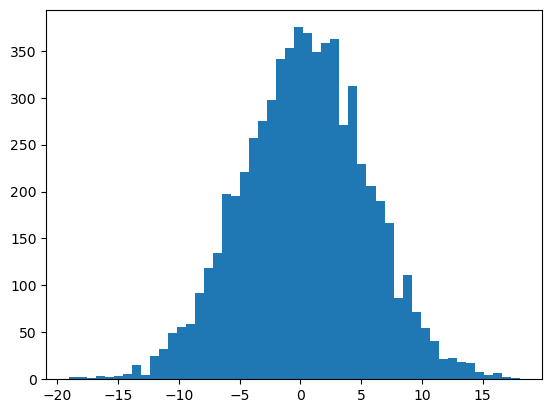

In [32]:

#hpreact = embcat @ W1+b1
plt.hist(hpreact.view(-1).tolist(),50);

$$
h = \tanh(h_{\text{preact}})
$$


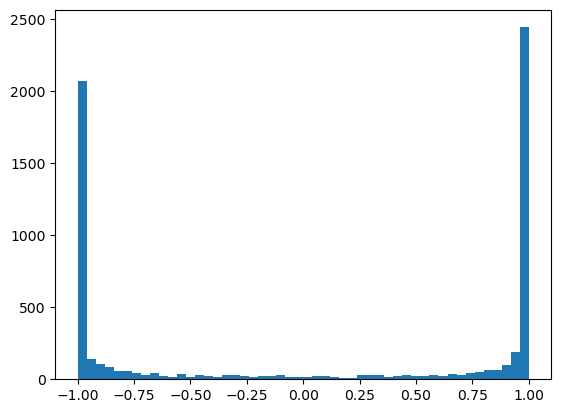

In [33]:
plt.hist(h.view(-1).tolist(),50);

## Effect of `tanh` Squashing on Initialization

When using the `tanh` activation, we observe that most hidden pre-activation values ($h_{\text{preact}}$) are squashed toward the extreme ends of **-1 and 1**. This saturation reduces gradient flow, making optimization harder. The issue arises when the pre-activation:

$$
h_{\text{preact}} = \text{embcat} \cdot W_1 + b_1
$$

is too large in magnitude, causing outputs to cluster at the boundaries. To optimize training more effectively, we must reduce these extreme values at initialization. By lowering weight scales, we keep $h_{\text{preact}}$ closer to zero, ensuring smoother gradients and better learning dynamics in the early stages.




If the values of $h_{\text{preact}}$ are too large, even after scaling, the extremes still squash toward **-1 and 1** under `tanh`.

To address this, we must directly reduce the magnitude of:

$$
h_{\text{preact}} = \text{embcat} \cdot W_1 + b_1
$$

This can be achieved by **scaling down $W_1$ and $b_1$ during initialization**.
- Smaller weights → logits closer to zero
- Outputs avoid saturation
- Gradients remain stronger

Thus, careful initialization ensures smoother optimization and prevents the network from starting in a saturated, high-loss state.



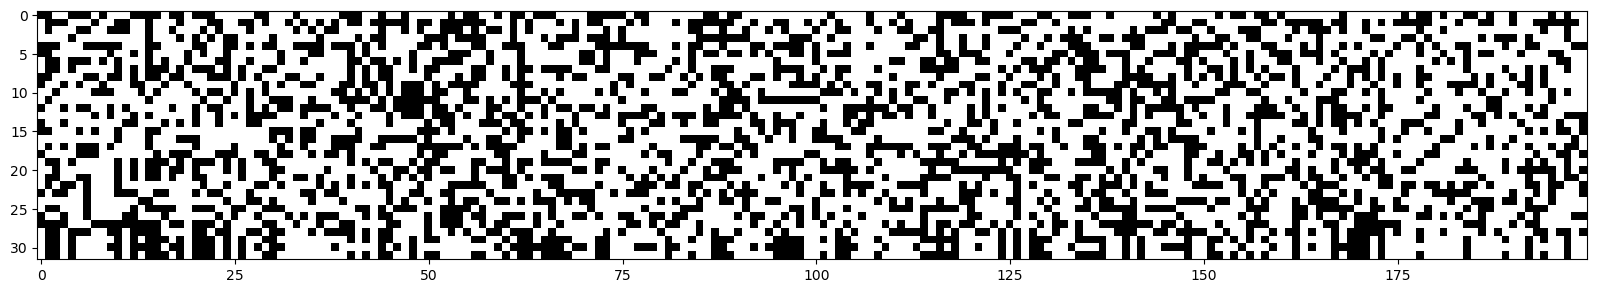

In [34]:
#This plot shows us how many dead neurons are present

plt.figure(figsize=(20,20))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation = 'nearest')

The heatmap `imshow(h.abs()>0.99)` marks saturated units in white. A dense, speckled field of white pixels means many neurons have $|h|>0.99$, yielding near-zero gradients. These “stuck” units barely update during backpropagation, slowing learning and increasing initial loss beyond the uniform baseline.

### Root Cause of Saturation

The saturation arises from the pre-activation values being too large in magnitude. Specifically:

$$
h_{\text{preact}} = \text{embcat} \cdot W_1 + b_1
$$

When $W_1$ and $b_1$ are initialized with high variance, the distribution of $h_{\text{preact}}$ spreads far from zero. Since the `tanh` activation compresses large positive or negative values toward **+1** or **−1**, most outputs end up saturated. In this state, the gradient $\tanh'(x) = 1 - \tanh^2(x)$ becomes nearly zero, causing vanishing gradients and preventing neurons from updating effectively.

---

### How to Avoid This

To avoid saturation, we need to control the scale of pre-activations:

- **Reduce initialization variance:** Use Xavier/Glorot or Kaiming initialization to keep values closer to zero.
- **Smaller weights and biases:** Directly scale down $W_1$ and $b_1$ at initialization.
- **Normalization layers:** Apply BatchNorm or LayerNorm to re-center and rescale activations.
- **Alternative activations:** Consider ReLU or LeakyReLU, which do not saturate symmetrically at both ends.
- **Data preprocessing:** Normalize input embeddings so they don’t amplify weights excessively.

By ensuring activations stay in the near-linear region of `tanh`, gradients remain strong, neurons stay “alive,” and the model can learn effectively.


## By changing the weigth of w1 and b1, we can decrease the logits i.e., h may be at that point we can reduce dead neurons which you can see in the above image

In [73]:
#

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


parameters = [C, W1, W2,b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1+b1 #+ b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer

  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

11897
      0/ 200000: 3.3135


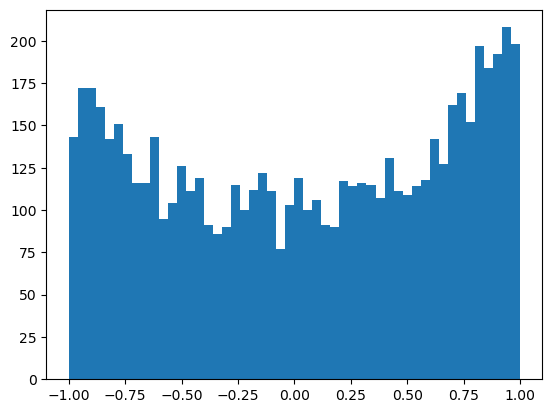

In [74]:
plt.hist(h.view(-1).tolist(),50);

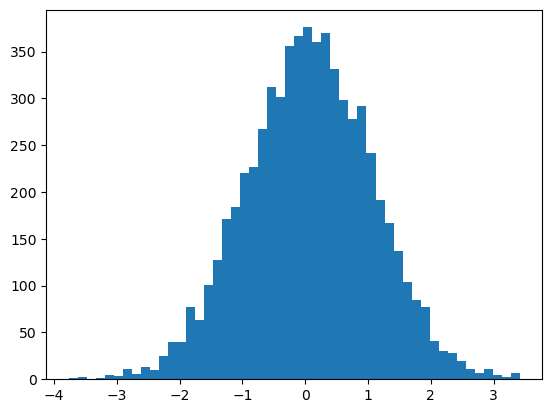

In [75]:
plt.hist(hpreact.view(-1).tolist(),50);

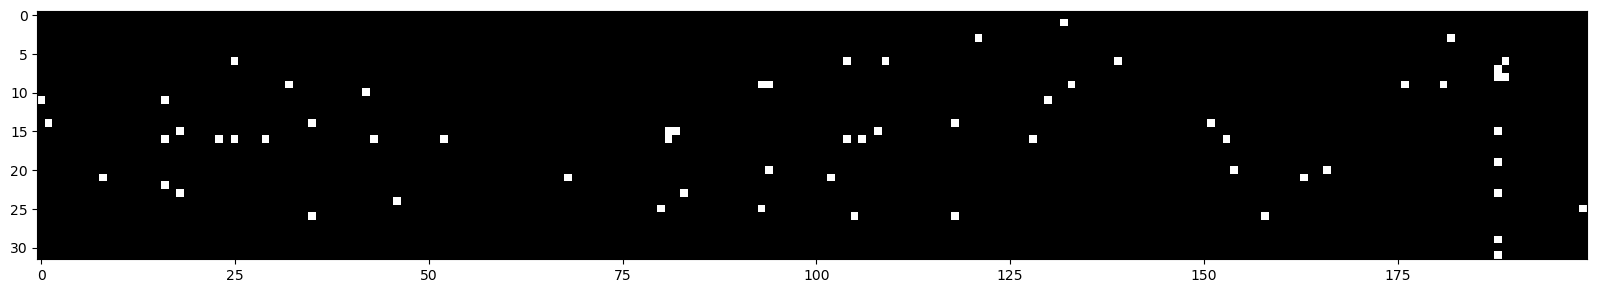

In [76]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation = 'nearest')

In [77]:
#the above plot look great so we will run the dull optimzation

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


parameters = [C, W1, W2,b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1+b1 #+ b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer

  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


In [78]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026782989501953


### Effect of Initialization and Activation Tuning on Training

- **Random initialization:**
  - Train loss: **2.1256**
  - Validation loss: **2.1674**

- **Adjusted initial weights (smaller scale):**
  - Lower starting loss observed
  - Train loss: **2.0681**
  - Validation loss: **2.1301**

- **Optimized `tanh` layer (reducing saturation):**
  - Further improvement in convergence
  - Train loss: **2.0356**
  - Validation loss: **2.1027**

---

### Observation

Each refinement (better initialization and reducing `tanh` saturation) lowered training and validation loss. However, when applying more **aggressive training**, overall accuracy unexpectedly went **down**. This suggests that while initialization and activation tuning improve stability and reduce loss, careful balance in training dynamics (learning rate, regularization, and overfitting control) is crucial to sustain accuracy improvements.


tensor(0.0016) tensor(1.0009)
tensor(-0.0100) tensor(3.2620)


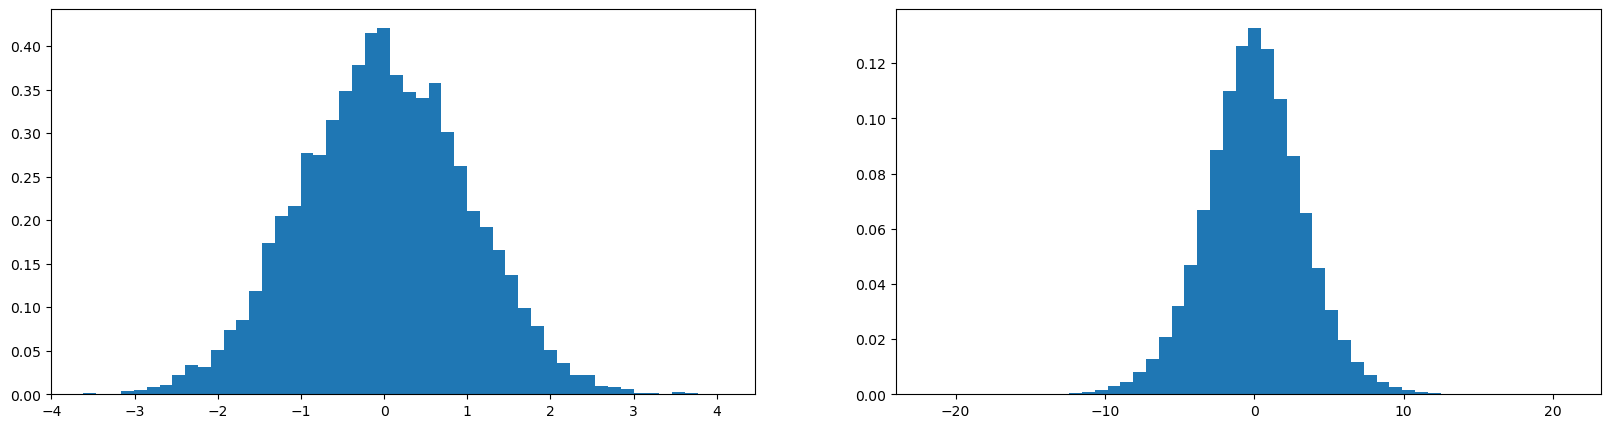

In [90]:
## Example

x= torch.randn(1000,10)
W =torch.randn(10,200)
y = x @ W
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

### Why the Variances Differ

- **Left plot (x):** Input sampled from a standard normal distribution with mean ~0 and variance ≈ 1.
- **Right plot (y):** After multiplying by weights, variance grows larger because each output sums contributions from many inputs. The variance of outputs scales with the **fan_in** (number of input connections).

---

### Fix with Kaiming Initialization

To keep variance stable, we rescale weights:

$$
\sigma_W = \frac{\text{gain}}{\sqrt{\text{fan\_in}}}
$$

- For ReLU: gain = $\sqrt{2}$
- For tanh: gain ≈ $5/3$
- For linear: gain = 1

This ensures output variance remains close to 1, avoiding exploding or vanishing activations.


tensor(-0.0113) tensor(1.0018)
tensor(0.0022) tensor(1.0059)


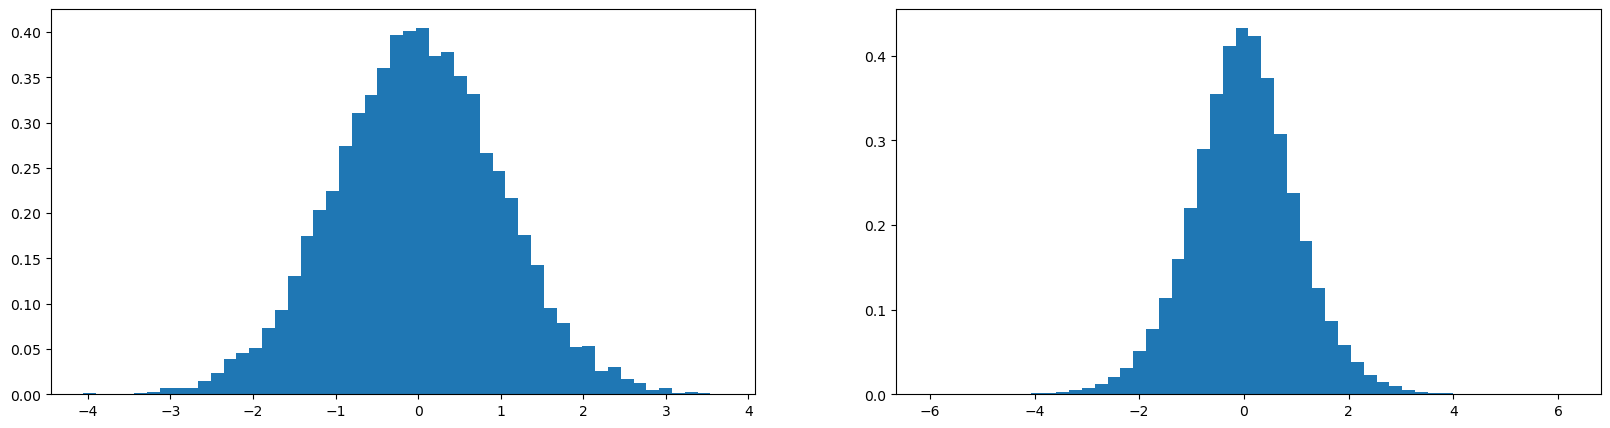

In [92]:
## Example

x= torch.randn(1000,10)
W =torch.randn(10,200) / 10 ** 0.5 # square root of fan in
y = x @ W
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# Kaiming (He) Initialization Paper

### Understanding Kaiming (He) Initialization – Beginner Friendly

When we build a neural network, we need to **set the initial weights** before training begins. If we pick numbers randomly (like multiplying by 0.01 or 0.001), training may still work, but it often becomes unstable when the network is deep. The problem is that activations (and gradients) can either **explode** (grow very large) or **vanish** (shrink to almost zero) as they pass through many layers. Both make learning very hard.

---

### Why Do Activations Explode or Vanish?

Let’s say each neuron takes multiple inputs, multiplies them by weights, and sums them up:

$$
h_{\text{preact}} = x \cdot W
$$

If the weights are too large, the outputs blow up. If they’re too small, the outputs collapse near zero. Ideally, we want the **spread** (variance or standard deviation) of activations to remain roughly the same across layers. This way, the signal flows smoothly forward, and gradients flow backward without dying out.

---

### The Idea of Kaiming Initialization

Kaiming (or He) Initialization gives us a **formula** for choosing the right scale for the weights so that the variance stays stable:

$$
W \sim \mathcal{N}\left(0, \frac{2}{\text{fan\_in}}\right)
$$

- **fan_in** = number of inputs to the neuron (e.g., if a layer takes 100 inputs, fan_in = 100).
- The **2** in the numerator comes from how ReLU activations drop half of the values to zero.
- For other activations like `tanh`, we use a different “gain” factor, but the principle is the same:
  keep the outputs well-behaved by dividing by $\sqrt{\text{fan\_in}}$.

---

### Why This Helps

Instead of guessing “magic numbers” like 0.01, Kaiming initialization automatically **scales weights based on layer size and activation type**. This ensures:
- Signals don’t shrink or explode as they pass through layers.
- Gradients flow better during backpropagation.
- Large, deep networks train more reliably.

---

✅ **Takeaway for Beginners:**
Kaiming Initialization is like a recipe that tells us how big or small the starting weights should be, based on the number of inputs and the activation function. This avoids the trial-and-error of picking constants and makes deep networks much easier to train.


In [96]:
#the above plot look great so we will run the dull optimzation

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


parameters = [C, W1, W2,b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1+b1 #+ b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer

  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


In [97]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376644134521484
val 2.106989622116089


### Initialization Then vs. Now

Around 7 years ago, weight initialization was very **fragile**. Small mistakes in setting gains, scaling, or activation choices could completely break training, especially in deep networks. Researchers had to carefully track histograms and tune values by hand to avoid exploding or vanishing activations.

---

### Modern Improvements

Today, training is much more stable because of:
- **Residual connections (ResNets):** make gradient flow easier.
- **Normalization layers:** BatchNorm, LayerNorm, GroupNorm stabilize activations.
- **Better optimizers:** Adam, RMSProp handle noisy gradients far better than plain SGD.

---

### Practical Rule

In practice, we usually just **normalize weights by the square root of the fan-in** (Kaiming/Xavier initialization). Frameworks like PyTorch implement this automatically, so we don’t need to manually fine-tune “magic numbers.”


## Using batch Normalization paper from 2015

### Batch Normalization Explained (Beginner Friendly)

#### 1. The Problem
When training deep neural networks, activations (the values flowing between layers) can become **too large** or **too small**:
- If too small → neurons stop learning (tanh becomes flat near 0).
- If too large → neurons saturate (tanh squashes to ±1, gradients vanish).

We want activations to stay **well-behaved**: roughly mean 0 and variance 1.
Before 2015, people had to carefully tune initialization and gains for every layer — this was fragile and hard to scale.

---

#### 2. The Big Idea (BatchNorm)
Batch Normalization (BN) says: instead of *hoping* activations stay nice, we can **normalize them directly** during training.

For each batch of activations $h_{\text{preact}}$ (before applying activation functions):

1. Compute the **mean**:
   $$
   \mu = \frac{1}{m}\sum_{i=1}^m h_i
   $$

2. Compute the **standard deviation**:
   $$
   \sigma = \sqrt{\frac{1}{m}\sum_{i=1}^m (h_i - \mu)^2}
   $$

3. Standardize activations:
   $$
   \hat{h} = \frac{h - \mu}{\sigma + \epsilon}
   $$

   (ε is a tiny number to avoid dividing by zero).

Now, every batch of activations has **mean 0** and **variance 1**. This keeps values stable for learning.

---

#### 3. Adding Flexibility (Scale and Shift)
If we always forced mean 0 and variance 1, the network might lose flexibility.
So BN introduces two trainable parameters for each neuron:
- **γ (gain)** → rescales activations
- **β (bias/shift)** → shifts activations

Final output:
$$
y = \gamma \hat{h} + \beta
$$

At the start: γ = 1, β = 0 → pure normalization.
During training, backpropagation learns the best γ and β values for each neuron.

---

#### 4. Why It Works
- Stabilizes activations → avoids exploding/vanishing values.
- Makes deep networks easier to train.
- Acts as a **regularizer**: because the mean/std come from the whole batch, each example’s output depends slightly on the others, adding noise and preventing overfitting.

---

#### 5. Training vs. Inference
- **During training**: BN computes mean/std from the current batch.
- **During inference (deployment)**: BN uses a **running average** of mean/std collected during training. This way, single inputs can be passed without depending on a batch.

---

#### 6. Practical Notes
- Layers before BN don’t need their own bias (BN will subtract it out).
- BN is often added **after every linear or convolution layer**.
- While newer methods (LayerNorm, GroupNorm, etc.) exist, BN is still widely used because it works reliably.

---

✅ **Summary in plain words:**
Batch Normalization is like giving each layer of a neural network a "reset button" that keeps its outputs well-scaled (not too big, not too small). It normalizes activations batch by batch, then lets the network learn how much to stretch (γ) or shift (β) them. This makes training deep networks much more stable and faster.
